## Temp

In [562]:
# General imports here.
import pandas as pd
import numpy as np
import sklearn as sk
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [563]:
# Read the csv files and index appropriately.
#ratings_small_df = pd.read_csv('./data/ratings_small.csv')
#ratings_df = pd.read_csv('./data/ratings.csv')
#links_small_df = pd.read_csv('./data/links_small.csv')
#links_df = pd.read_csv('./data/links.csv')
keywords_df = pd.read_csv('./data/keywords.csv')
credits_df = pd.read_csv('./data/credits.csv')
metadata_df = pd.read_csv('./data/movies_metadata.csv')
# Reading the movies_metadata.csv file throws a DtypeWarning.
# It's the popularity feature. I deleted it.

In [564]:
print(metadata_df.id.unique())
print(metadata_df.id.dtype)
# If dtype is not int64, go to the metadata CSV and delete all entries where 'adult' is not false.
# I also deleted the adult column afterwards.

[   862   8844  15602 ...,  67758 227506 461257]
int64


In [565]:
# These three files seem to be the ones we want. Indexed on ID, we could probably combine them now.
dataframes = (keywords_df, credits_df, metadata_df)
# Pandas DataFrames don't have name attributes.
df_names = ("keywords", "credits", "movies_metadata")
keywords_df = keywords_df.set_index('id')
credits_df = credits_df.set_index('id')
metadata_df = metadata_df.set_index('id')
None

In [566]:
# Join the useful data frames together
temp = keywords_df.join(credits_df)
movie_df = metadata_df.join(temp)
movie_df.head(2)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,cast,crew
id,,,,,,,,,,,,,,,,,,,,,
2,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg,"[{'name': 'Villealfa Filmproduction Oy', 'id':...",...,"[{'iso_639_1': 'fi', 'name': 'suomi'}, {'iso_6...",Released,NaN,Ariel,False,7.1,44.0,"[{'id': 240, 'name': 'underdog'}, {'id': 378, ...","[{'cast_id': 3, 'character': 'Taisto Olavi Kas...","[{'credit_id': '52fe420dc3a36847f800001f', 'de..."
3,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",/7ad4iku8cYBuB08g9yAU7tHJik5.jpg,"[{'name': 'Villealfa Filmproduction Oy', 'id':...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Shadows in Paradise,False,7.1,35.0,"[{'id': 1361, 'name': 'salesclerk'}, {'id': 17...","[{'cast_id': 5, 'character': 'Nikander', 'cred...","[{'credit_id': '52fe420dc3a36847f8000077', 'de..."


In [567]:
# Toy Story Entry
movie_df.loc[862]

belongs_to_collection    {'id': 10194, 'name': 'Toy Story Collection', ...
budget                                                            30000000
genres                   [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
homepage                              http://toystory.disney.com/toy-story
imdb_id                                                          tt0114709
original_language                                                       en
original_title                                                   Toy Story
overview                 Led by Woody, Andy's toys live happily in his ...
poster_path                               /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
production_companies        [{'name': 'Pixar Animation Studios', 'id': 3}]
production_countries     [{'iso_3166_1': 'US', 'name': 'United States o...
release_date                                                    10/30/1995
revenue                                                        3.73554e+08
runtime                  

In [568]:
print("NaN Values: \n")
print(movie_df.isnull().sum())

NaN Values: 

belongs_to_collection    42046
budget                       0
genres                       0
homepage                 38613
imdb_id                     17
original_language           11
original_title               0
overview                   995
poster_path                399
production_companies         4
production_countries         4
release_date                87
revenue                      4
runtime                    268
spoken_languages             4
status                      86
tagline                  25843
title                        4
video                        4
vote_average                 4
vote_count                   4
keywords                     1
cast                         1
crew                         1
dtype: int64


In [569]:
# Lots of NaNs, just print out the first couple of entries to see what's going on.
movie_df.head(2)
# belongs_to_collection seems fine, that's not simple data and is probably just Python being confused about what to expect.
# homepage throws NaN when there's not a homepage it seems. Probably want to do a one-hot replacement here.
# imdb_id is missing 17 IDs, we should probably just drop these movies.
# original_language: 11, just drop them.
# overview:
# poster_path:
# production (general): Just names of companies/countries. Just drop the 3 movies.
# release_date: should probably just drop the samples with missing values, I can't think of a way to fill in the values.
# revenue, spoken languages, title, video, votes all have 4 NaNs. I'd wager they're the same movies, we should drop the samples.
# runtime: We can probably just fill in with a mean/median.
# status: We should do some sort of hot-encoding here, then the NaNs will just be columns of 0. Will print uniques to check.
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence one-hot variable
# Keywords, cast, & crew:

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,cast,crew
id,,,,,,,,,,,,,,,,,,,,,
2,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg,"[{'name': 'Villealfa Filmproduction Oy', 'id':...",...,"[{'iso_639_1': 'fi', 'name': 'suomi'}, {'iso_6...",Released,NaN,Ariel,False,7.1,44.0,"[{'id': 240, 'name': 'underdog'}, {'id': 378, ...","[{'cast_id': 3, 'character': 'Taisto Olavi Kas...","[{'credit_id': '52fe420dc3a36847f800001f', 'de..."
3,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",/7ad4iku8cYBuB08g9yAU7tHJik5.jpg,"[{'name': 'Villealfa Filmproduction Oy', 'id':...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Shadows in Paradise,False,7.1,35.0,"[{'id': 1361, 'name': 'salesclerk'}, {'id': 17...","[{'cast_id': 5, 'character': 'Nikander', 'cred...","[{'credit_id': '52fe420dc3a36847f8000077', 'de..."


In [570]:
print(movie_df.status.unique())
# 6 one-hot variables don't seem too bad. It's an option.

['Released' 'In Production' 'Rumored' 'Planned' nan 'Post Production'
 'Canceled']


In [571]:
movie_df.describe()

,budget,revenue,runtime,vote_average,vote_count
count,4.662000e+04,4.661600e+04,46352.000000,46616.000000,46616.00000
mean,4.164335e+06,1.102954e+07,94.089619,5.611934,108.18676
std,1.727566e+07,6.381057e+07,38.454552,1.932187,486.46931
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000
25%,0.000000e+00,0.000000e+00,85.000000,5.000000,3.00000
50%,0.000000e+00,0.000000e+00,95.000000,6.000000,10.00000
75%,0.000000e+00,0.000000e+00,107.000000,6.800000,34.00000
max,3.800000e+08,2.787965e+09,1256.000000,10.000000,14075.00000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B604B58748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001B604A46EB8>]], dtype=object)

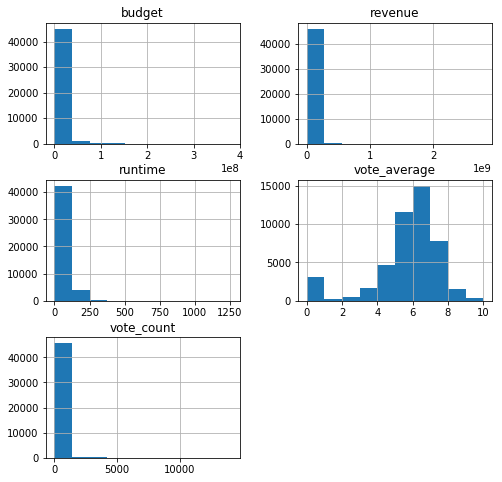

In [572]:
movie_df.hist(figsize=(8,8))

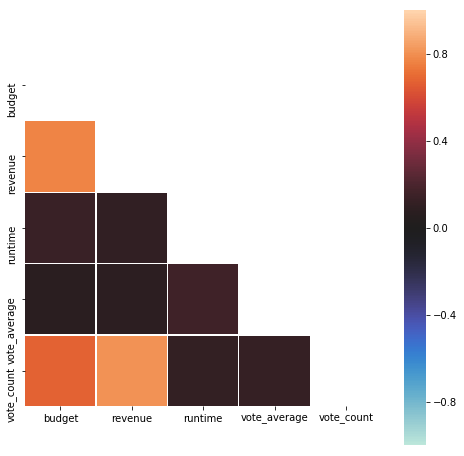

In [573]:
# A quick heatmap. It seems revenue and the number of votes are correlated.
import seaborn as sns
corr = movie_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 8))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=False, linewidths=0.2, center=0)